In [1]:
using Gen
using Plots
using DelimitedFiles

In [2]:
# might take a couple of minutes
# we need to install the package Distributions in this way, b/c it's not part of the container
using Pkg
Pkg.activate("myenv")
Pkg.add("Distributions")
using Distributions

  Activating project at `~/Algorithms-of-the-Mind/lectures/lecture-07/myenv`
┌ Warning: could not download https://pkg.julialang.org/registries
│   exception = RequestError: Failed to connect to pkg.julialang.org port 443 after 15203 ms: Connection timed out while requesting https://pkg.julialang.org/registries
└ @ Pkg.Registry /opt/julia-1.9.3/share/julia/stdlib/v1.9/Pkg/src/Registry/Registry.jl:69
   Resolving package versions...
  No Changes to `~/Algorithms-of-the-Mind/lectures/lecture-07/myenv/Project.toml`
  No Changes to `~/Algorithms-of-the-Mind/lectures/lecture-07/myenv/Manifest.toml`


In [3]:
# helper function
function logmeanexp(scores)
    logsumexp(scores) - log(length(scores))
end;

# Importance sampling from scratch

### Define the generative model

In [ ]:
# same as above, but using the ~ notation
@gen function unknown_urn()
    # p(θ) ̃Uniform(0,1)  [prior distribution]
    theta ~ uniform(0, 1)
    for i=1:10
        # p(y=1|θ) ~ Bernoulli(θ) [likelihood function]
        {:data => i => :y} ~ bernoulli(theta)
    end
end

### Make observations

In [ ]:
# helper function to create a choicemap with the observed data xs
function make_constraints(ys::Vector{Bool})
    # choicemap to encode observations
    constraints = Gen.choicemap()
    # fill in the choicemap with the observed draws
    for i=1:length(ys)
        constraints[:data => i => :y] = ys[i]
    end
    # return the observations
    constraints
end

# **** Start reading this codeblock from here: ****
# we will store observations in a Boolean array
draws = Bool[]
# true=red marble; false=blue marble
# typically data is something we read from file, but in this case we will hand-code it
draws = [true, true,true, true, true, true, false, true, false, true]
observations = make_constraints(draws)

### Importance sampling using the prior itself as the proposal

In [ ]:
# draw K samples from the joint P(θ, y)
# initialize
K = 100 # (try 10, 1000, or something else)
traces = Vector{Any}(undef, K)
interim_weights = Vector{Float64}(undef, K)
thetas = Vector{Float64}(undef, K)
# use Gen.generate to get a trace from the prior and its weight
# Here our q(x) is the prior itself p(θ, y)
# We could have done Gen.simulate, but it'd have not returned weights
# Notice that we are sampling the θs from its prior
for k in 1:K
    (traces[k], interim_weights[k]) = Gen.generate(unknown_urn, (), choicemap(observations)) 
    thetas[k] = traces[k][:theta]
end

# calculate the log normalized importance weights; simply divide by the sum of all interim weights (in log space for numeric stability) 
importance_weights = interim_weights .- logmeanexp(interim_weights) 

# exponentiate to bring back to the prob space
importance_weights = exp.(importance_weights)

### Visualize

In [ ]:
# plot the prior
scatter(thetas, ones((K, 1)), ylims=(-0.5,5), label="θ")
# now plot the estimated posterior
scatter!(thetas, importance_weights, ylims=(-0.5, 5), label="θ", c="red")

### Approximate the expected value of the posterior via the Monte Carlo principle

In [ ]:
# Approximate the expectation E[θ] = ∫θ p(θ|obs)
avg = sum(thetas .* importance_weights)/K

### For your ref: Importance (re)sampling using Gen's MCMC library implementation

In [ ]:
# the posterior p(θ|observations)
# using "importance resampling" from Gen's library of inference methods
# we run this algorithm 100 times and record the output
traces = [first(Gen.importance_resampling(unknown_urn, (), observations, 1000)) for i in 1:100]

# collect the inferred θs across these 100 chains and plot
thetas = Float64[]
thetas = [t[:theta] for t in traces]
histogram(thetas, label="θ")

# Change point model 

### A generative model for change point

In [4]:
@gen function change_point(N::Int=50)
    # year of change in regulations
    n ~ uniform_discrete(1, N)
    # intensity parameters before and after
    lambda1 ~ gamma(2, 1)
    lambda2 ~ gamma(2, 1)
    # draw a count for each year using its intensity param.
    for k=1:N
        {:data => k => :y} ~ poisson(k <= n ? lambda1 : lambda2)
    end
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64], true, Union{Nothing, Some{Any}}[Some(50)], var"##change_point#292", Bool[0], false)

In [28]:
(trace, _) = Gen.generate(change_point, ())
get_choices(trace)

│
├── :lambda1 : 2.59319207199809
│
├── :n : 41
│
├── :lambda2 : 3.9217782629346054
│
└── :data
    │
    ├── 5
    │   │
    │   └── :y : 6
    │
    ├── 35
    │   │
    │   └── :y : 4
    │
    ├── 30
    │   │
    │   └── :y : 4
    │
    ├── 32
    │   │
    │   └── :y : 2
    │
    ├── 6
    │   │
    │   └── :y : 6
    │
    ├── 45
    │   │
    │   └── :y : 8
    │
    ├── 4
    │   │
    │   └── :y : 5
    │
    ├── 13
    │   │
    │   └── :y : 2
    │
    ├── 12
    │   │
    │   └── :y : 2
    │
    ├── 28
    │   │
    │   └── :y : 3
    │
    ├── 23
    │   │
    │   └── :y : 3
    │
    ├── 41
    │   │
    │   └── :y : 2
    │
    ├── 43
    │   │
    │   └── :y : 5
    │
    ├── 11
    │   │
    │   └── :y : 1
    │
    ├── 36
    │   │
    │   └── :y : 4
    │
    ├── 39
    │   │
    │   └── :y : 2
    │
    ├── 7
    │   │
    │   └── :y : 4
    │
    ├── 25
    │   │
    │   └── :y : 1
    │
    ├── 34
    │   │
    │   └── :y : 2
    │
    ├── 50
    │   │
    │  

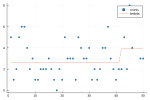

In [29]:
N=50
x = range(1, N, length=N)
y1 = [trace[:data => k => :y] for k=1:N]
y2 = [repeat([trace[:lambda1]], (trace[:n]));  repeat([trace[:lambda2]], (50-trace[:n]))]

plot(x, y1, label="counts", seriestype=:scatter)
plot!(x, y2, label="lambda")

In [7]:
# we had used simulated data to create our dataset -- 
#writedlm("count_data-new.txt", y1)

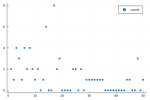

In [30]:
# helper function to create a choicemap with the observed data xs
function make_constraints(xs::Vector{})
    # choicemap to encode observations
    constraints = Gen.choicemap()
    # fill in the choicemap with the observed draws
    for i=1:length(xs)
        constraints[:data => i => :y] = xs[i]
    end
    # return the observations
    constraints
end
# read the dataset and load up as a choicemap
y1 = readdlm("count_data.txt")[:,1]
x = range(1, N, length=N)
observations = make_constraints(y1)
plot(x, y1, label="counts", seriestype=:scatter)

### Block Resimulation MH

In [9]:
# may be update a block using mh
function block_resimulation_update(tr)
    # update the lambda parameters
    lambda_params = select(:lambda1, :lambda2)
    (tr, _) = mh(tr, lambda_params)

    # update change point, n
    cp = select(:n)
    (tr, _) = mh(tr, cp)

    # return the updated trace
    tr
end

block_resimulation_update (generic function with 1 method)

In [10]:
function block_resimulation_inference(observations)
    # initialize the chain
    (tr, _) = generate(change_point, (), observations)
    # the inference loop
    for iter=1:500
        # may be update the latents
        tr=block_resimulation_update(tr)
    end
    tr
end 

block_resimulation_inference (generic function with 1 method)

In [11]:
scores = Vector{Float64}(undef, 10)
inferred_lambda = zeros(Float64, 10, 2)
inferred_n = Vector{Int}(undef, 10)
for i=1:10
    @time tr = block_resimulation_inference(observations)
    scores[i] = get_score(tr)
    inferred_lambda[i,:] = [tr[:lambda1], tr[:lambda2]]
    inferred_n[i] = tr[:n]
end
println("Log probability: ", logmeanexp(scores))

  0.838047 seconds (2.22 M allocations: 157.598 MiB, 5.27% gc time, 72.90% compilation time)
  0.224709 seconds (1.59 M allocations: 122.823 MiB, 15.99% gc time)
  0.205771 seconds (1.59 M allocations: 122.823 MiB, 8.24% gc time)
  0.214975 seconds (1.59 M allocations: 122.823 MiB, 13.51% gc time)
  0.214547 seconds (1.59 M allocations: 122.823 MiB, 13.59% gc time)
  0.216605 seconds (1.59 M allocations: 122.823 MiB, 13.46% gc time)
  0.200226 seconds (1.59 M allocations: 122.823 MiB, 7.28% gc time)
  0.214954 seconds (1.59 M allocations: 122.823 MiB, 13.56% gc time)
  0.214408 seconds (1.59 M allocations: 122.823 MiB, 13.49% gc time)
  0.205626 seconds (1.59 M allocations: 122.823 MiB, 7.06% gc time)
Log probability: -78.63316928179339


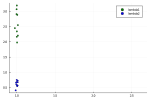

In [12]:
plot(repeat([1], 10) + 0.01*randn(10), inferred_lambda[:,1],  seriestype=:scatter, label="lambda1", color="green")
plot!(repeat([1], 10) + 0.01*randn(10), inferred_lambda[:,2], seriestype=:scatter, label="lambda2", color="blue")
xlims!(0.9, 2.7)

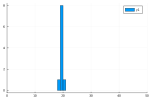

In [13]:
plot(inferred_n, seriestype=:histogram)
xlims!((0, N))

In [14]:
function visualize_trace(trace; title)
    N = 50
    x = range(1, N, length=N)
    y1 = [trace[:data => k => :y] for k=1:N]
    y2 = [repeat([trace[:lambda1]], (trace[:n]));  repeat([trace[:lambda2]], (50-trace[:n]))]

    plot(x, y1, label="counts", seriestype=:scatter, title=title)
    plot!(x, y2, label="lambda")
end

visualize_trace (generic function with 1 method)

┌ Info: Saved animation to 
└   fn = "/home/psyc261_iy42/Algorithms-of-the-Mind/lectures/lecture-07/tmp.gif"


Plots.AnimatedGif("/home/psyc261_iy42/Algorithms-of-the-Mind/lectures/lecture-07/tmp.gif")
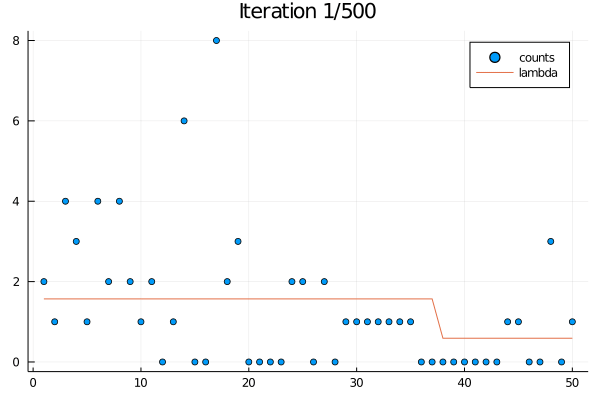

In [15]:
t, = generate(change_point, (), observations)

viz = Plots.@animate for i in 1:500
    global t
    t = block_resimulation_update(t)
    visualize_trace(t; title="Iteration $i/500")
end;
gif(viz)

### Random-walk MH

In [16]:
# include the truncated norm distribution
include("truncatednorm.jl")

In [31]:
@gen function intensity_proposal(current_trace)
    # trunc_norm(mean, std, lower_bound, upper_bound)
    # why do we need a truncated norm, instead of a regular normal distribution?
    lambda1 ~ trunc_norm(current_trace[:lambda1], 0.5, 0., 10.)
    lambda2 ~ trunc_norm(current_trace[:lambda2], 0.5, 0., 10.)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##intensity_proposal#1308", Bool[0], false)

In [18]:
function random_walk_mh(tr)
    
    # make a random-walk update on lambdas
    (tr, _) = mh(tr, intensity_proposal, ())

    # block resimulation for the change point index
    # update change point, n
    cp = select(:n)
    (tr, _) = mh(tr, cp)

    # return the updated trace
    tr
end

random_walk_mh (generic function with 1 method)

┌ Info: Saved animation to 
└   fn = "/home/psyc261_iy42/Algorithms-of-the-Mind/lectures/lecture-07/tmp.gif"


Plots.AnimatedGif("/home/psyc261_iy42/Algorithms-of-the-Mind/lectures/lecture-07/tmp.gif")
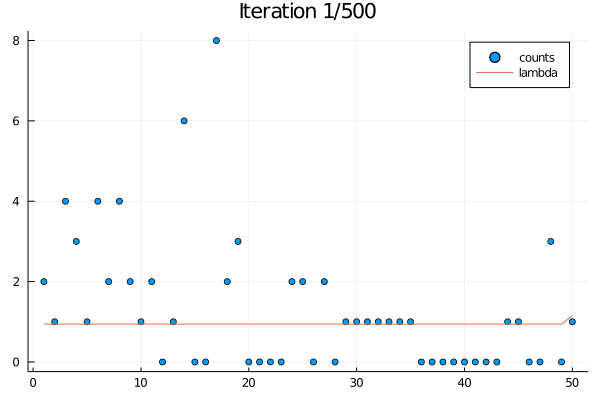

In [19]:
t, = generate(change_point, (), observations)

viz = Plots.@animate for i in 1:500
    global t
    t = random_walk_mh(t)
    visualize_trace(t; title="Iteration $i/500")
end;
gif(viz)

In [ ]:
scores = Vector{Float64}(undef, 10)
inferred_lambda = zeros(Float64, 10, 2)
inferred_n = Vector{Int}(undef, 10)
for i=1:10
    (tr, _) = generate(change_point, (), observations)
    for k in 1:500
        tr = random_walk_mh(tr)
    end
    scores[i] = get_score(tr)
    inferred_lambda[i,:] = [tr[:lambda1], tr[:lambda2]]
    inferred_n[i] = tr[:n]
end
println("Log probability: ", logmeanexp(scores))

In [ ]:
plot(repeat([1], 10) + 0.01*randn(10), inferred_lambda[:,1],  seriestype=:scatter, label="lambda1", color="green")
plot!(repeat([1], 10) + 0.01*randn(10), inferred_lambda[:,2], seriestype=:scatter, label="lambda2", color="blue")
xlims!(0.9, 2.7)

In [ ]:
plot(inferred_n, seriestype=:histogram)
xlims!((0, N))